In [18]:
from control import *
import numpy as np
import matplotlib.pyplot as plt

In [57]:
# kp, ki, kd
# 0.005493331705679495, 0.00024414807580797754, 30.81524926686217
# 3.9100684261974585, 18.57282502443793, 912.0234604105572
# 0.9775171065493646, 0.9775171065493646, 999.0224828934506
# 4.887585532746823, 275.65982404692085, 984.3597262952102
# 7.820136852394917, 85.04398826979472, 936.4613880742913
# 31.28054740957967, 44.965786901270775, 956.989247311828
# 8.79765395894428, 75.26881720430107, 947.2140762463343
kp = 31.28054740957967
ki = 44.965786901270775
kd = 947.2140762463343

In [58]:
plant = tf([1], [64,9.6,0.48,0.008])
pid = tf([kd,kp,ki], [1,0])

In [59]:
plant


                1
---------------------------------
64 s^3 + 9.6 s^2 + 0.48 s + 0.008

In [60]:
sys = feedback(pid, plant, sign=1)

In [61]:
time = np.arange(0,90)

In [62]:
sys1 = feedback(pid*plant, 1)

<function matplotlib.pyplot.show>

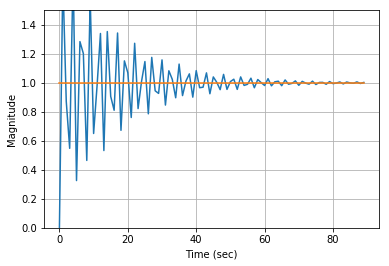

In [63]:
# PID compensated Step Response
t, s = step_response(sys1,T=time)
target = np.linspace(1, 1, num=len(t))
plt.figure()
plt.plot(t,s,t,target)
#plt.plot(t,s)
plt.ylim([0,1.5])
plt.ylabel(r'Magnitude')
plt.xlabel(r'Time (sec)')
plt.grid()
plt.show

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from control import *

In [ ]:
# Plant
num = [1]
den = [64,9.6,0.48,0.008]
G = tf(num, den)

# Plant Step Response
t, s = step_response(G)

#PID Controller
kp = 0.0361 
ki = 0.000731
kd = 0.6999

pid_num = [kd, kp, ki]
pid_den = [1, 0]
C = tf(pid_num,pid_den)

# System
T = feedback(C*G,1)

In [ ]:
# PID compensated Step Response
t, s = step_response(T)
target = np.linspace(1, 1, num=len(t))
plt.figure()
plt.plot(t,s,t,target)
#plt.plot(t,s)
plt.ylim([0,1.5])
plt.ylabel(r'Magnitude')
plt.xlabel(r'Time (sec)')
plt.grid()
plt.show

error = target - s

In [1]:
import matplotlib
import numpy
from control import *
import math

In [2]:
from deap import base, creator
# Crear clase FITNESS: ( Nombre de la clase, Delegando la clase como fitness, Posibles valores min y max del fitness )
creator.create("ControllerFitness", base.Fitness, weights=(1.0,))

# Crear clase CROMOSOMA: ( Nombre de la clase, type de los valores de la clase, Establecer fitness con la clase anterior )
creator.create("Controller", list, fitness=creator.ControllerFitness)

In [3]:
import random
from deap import tools

IND_SIZE = 30 # ki bits + kp bits + kd bits

# Functions to initialize populations from individuals

toolbox = base.Toolbox()

# Crear el ATRIBUTO de cromosomas ( Nombre del registro para el toolbox, Función para crear un cromosoma aleatorio )
toolbox.register("bit_attribute", random.randint, 0, 1) # random.choice, '10')

# Crear el CROMOSOMA ( Nombre del registro, , La clase cromosoma, La clase atributo, Tamaño de la población )
# Cuando se llame a toolbox.individual(), este llamará a tool.initRepeat()
toolbox.register("controller", tools.initRepeat, creator.Controller, toolbox.bit_attribute, n=IND_SIZE)

# Crear la POBLACIÓN ( Nombre del registro, , Type del cromosoma, El cromosoma )
toolbox.register("population", tools.initRepeat, list, toolbox.controller)

In [4]:
ind = toolbox.controller()

In [70]:
def evaluate(controller):
    controller = ''.join(map(str,controller))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (math.pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (math.pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (math.pow(2,10) - 1) )
    
    # Plant
    num = [1]
    den = [64,9.6,0.48,0.008]
    plant = tf(num, den)
    
    pid_num = [kd, kp, ki]
    pid_den = [1, 0]
    pid = tf(pid_num,pid_den)

    # System
    sys = feedback(pid*plant,1)
    
    # PID compensated Step Response
    time = np.arange(0,900)
    t, s = step_response(sys,T=time)
    l = len(t)
    
    #total_error = sum(abs(1 - s))
    
    #total_error = sum(map(lambda x:abs(1-x)/l,s))
    
    total_error = 0
    while (1-s[l-total_error-1]) < 0.01:
        total_error = total_error + 1
    
    return (total_error),

In [71]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

In [72]:
ind = toolbox.controller()

In [73]:
def main():
    pop = toolbox.population(n=40)
    # pop[0:100] = prev
    CXPB, MUTPB, NGEN = 0.7, 0.1, 40

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    minFit = (1,)
    #while minFit > (0.02,):
    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        minFit = min(fitnesses)
        print("=START=================================================================")
        print(fitnesses)
        print("=END===================================================================")
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
    
    
    return pop

In [74]:
w = [1,2,3,4]
w[len(w)-1]

4

In [75]:
kx = main()

=START=================================================================
[(1,), (1,), (1,), (778,), (2,), (0,), (1,), (0,), (0,), (0,), (1,), (0,), (0,), (1,), (2,), (0,), (0,), (1,), (1,), (0,), (198,), (0,), (721,), (1,), (2,)]
=END===================================================================
=START=================================================================
[(0,), (821,), (1,), (0,), (799,), (1,), (818,), (0,), (198,), (198,), (0,), (823,), (218,), (2,), (809,), (769,), (284,), (198,), (0,), (0,), (721,), (1,), (2,), (823,), (0,), (1,), (0,), (198,), (284,)]
=END===================================================================
=START=================================================================
[(0,), (1,), (198,), (284,), (779,), (733,), (0,), (779,), (822,), (2,), (778,), (778,), (823,), (0,), (737,), (761,), (778,), (778,), (778,), (778,), (778,), (785,), (0,), (811,), (778,), (769,), (742,), (1,), (0,), (1,), (823,), (0,)]
=END=====================================

=START=================================================================
[(840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (838,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (825,), (0,), (840,), (840,), (797,), (840,), (840,), (840,), (840,)]
=END===================================================================
=START=================================================================
[(840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (840,), (837,), (840,), (840,), (840,), (840,), (840,), (840,)]
=END===================================================================
=START=================================================================
[(840,), (840,), (840,), (840,), (833,), (840,), (840,), (840,), (840,), (840,), (1,), (840,), (840,), (840,), (840,), (0,), (840,), (840,), (84

In [76]:
for bits in kx:
    controller = ''.join(map(str,bits))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (pow(2,10) - 1) )
    
    print([_kp,_ki,_kd,kp,ki,kd])

[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 9, 961, 8.79765395894428, 8.79765395894428, 939.3939393939394]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[13, 77, 969, 12.70772238514174, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 75.26881720430107, 947.2140762463343]
[41, 77, 969, 40.07820136852395, 75.26881720430107, 947.2140762463343]
[9, 77, 969, 8.79765395894428, 7

In [54]:
evaluate(kx[1])

(790,)

In [55]:
list(map(evaluate,kx))

[(790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (785,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (703,),
 (790,),
 (766,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (703,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (650,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,),
 (790,)]

In [ ]:
controller = ''.join(map(str,kx[1]))
    
# PID controller
_kp = int(controller[0:10],2)
_ki = int(controller[10:20],2)
_kd = int(controller[20:30],2)

kp = 0 + _kp * ( (1000 - 0) / (pow(2,10) - 1) )
ki = 0 + _ki * ( (1000 - 0) / (pow(2,10) - 1) )
kd = 0 + _kd * ( (1000 - 0) / (pow(2,10) - 1) )
    
print([_kp,_ki,_kd,kp,ki,kd])